## T4 MFRFN Chakravarty, S., Demirhan, H., & Baser, F. (2022). Modified fuzzy regression functions with a noise cluster against outlier contamination. Expert Systems with Applications, 205, 117717. https://doi.org/10.1016/j.eswa.2022.117717

   Gender  Hemoglobin   MCH  MCHC   MCV  Result
0       1        14.9  22.7  29.1  83.7       0
1       0        15.9  25.4  28.3  72.0       0
2       0         9.0  21.5  29.6  71.2       1
3       0        14.9  16.0  31.4  87.5       0
4       1        14.7  22.0  28.2  99.5       0
Silhouette Score: 0.013641175353449757
Davies-Bouldin Index: 4.289444962686857
S/DB Ratio: 0.0031801726032416764
Number of Outliers: 605
Percentage of Outliers: 42.58%
AUC Value: 0.46500140952841207


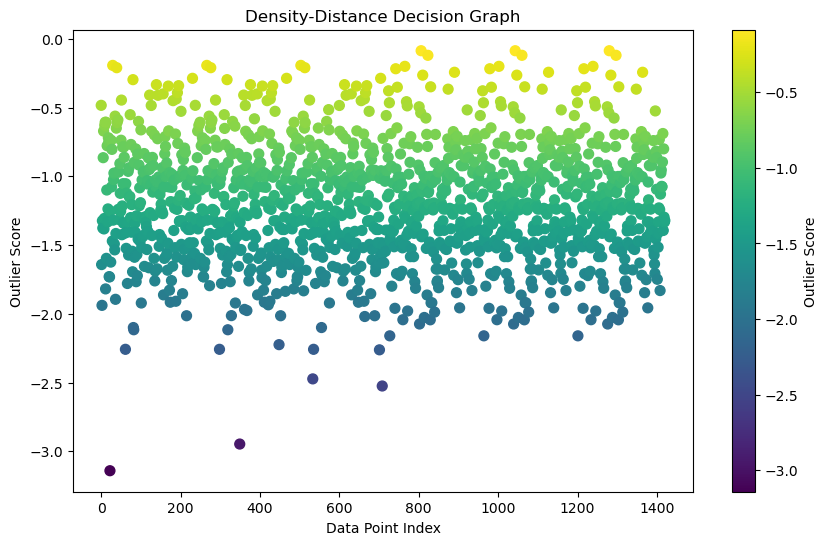

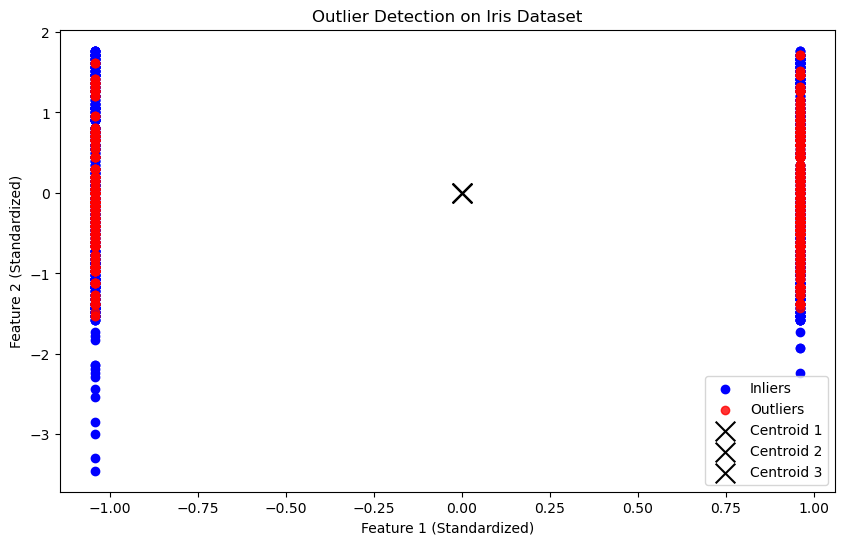

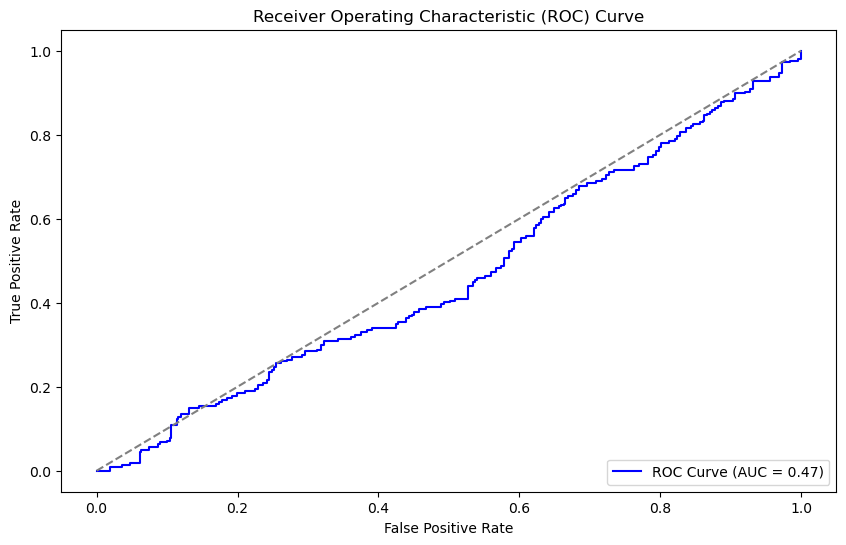

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from fcmeans import FCM  # Install using: pip install fuzzy-c-means
from sklearn.metrics import silhouette_score, davies_bouldin_score, roc_curve, auc
from scipy.spatial.distance import cdist

# # Load and preprocess the Iris dataset
# Data = datasets.load_iris()
# X = Data.data
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

file_path = r"D:\Research Related\30 Deep Robust Clustering with Mahalanobis Distance (DRCMD)\dataset\anemia.csv"
# Load the dataset into a pandas DataFrame
data = pd.read_csv(file_path)
# Display the first few rows of the dataset to understand its structure
print(data.head())
# Remove the last column
# Separate the features (X) and the target variable (y_true)
X = data.iloc[:, :-1]  # All columns except the last
y_true = data.iloc[:, -1]  # The last column

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Parameters for fuzzy c-means with noise cluster
n_clusters = 3
fuzziness = 2.0
noise_distance = 1.5

# Fuzzy C-Means with Noise Cluster Implementation
class FCMWithNoiseCluster:
    def __init__(self, n_clusters, fuzziness, noise_distance):
        self.n_clusters = n_clusters
        self.fuzziness = fuzziness
        self.noise_distance = noise_distance

    def fit(self, X):
        fcm = FCM(n_clusters=self.n_clusters)
        fcm.fit(X)
        self.memberships = fcm.u
        self.centers = fcm.centers

        # Add noise cluster
        distances = np.min(np.linalg.norm(X[:, None] - self.centers, axis=2), axis=1)
        noise_membership = 1 / (1 + (distances / self.noise_distance) ** (2 / (self.fuzziness - 1)))
        self.memberships = np.hstack((self.memberships, noise_membership[:, None]))

    def predict(self, X):
        cluster_assignments = np.argmax(self.memberships, axis=1)
        return cluster_assignments

# Apply FCM with Noise Cluster
fcm_nc = FCMWithNoiseCluster(n_clusters=n_clusters, fuzziness=fuzziness, noise_distance=noise_distance)
fcm_nc.fit(X_scaled)
labels = fcm_nc.predict(X_scaled)

# Identify noise points (outliers)
outlier_mask = labels == n_clusters
outliers = X_scaled[outlier_mask]
outliers_count = len(outliers)
outliers_percentage = (outliers_count / len(X_scaled)) * 100

# Calculate evaluation metrics
silhouette = silhouette_score(X_scaled, labels[:len(X_scaled)])
davies_bouldin = davies_bouldin_score(X_scaled, labels[:len(X_scaled)])
s_db_ratio = silhouette / davies_bouldin if davies_bouldin != 0 else None

# AUC Calculation (Use actual true labels)
true_labels = y_true  # True labels extracted from the dataset
predicted_scores = fcm_nc.memberships[:, -1]  # Membership scores for the noise cluster
fpr, tpr, _ = roc_curve(true_labels, predicted_scores)
roc_auc = auc(fpr, tpr)

# Print metrics
print("Silhouette Score:", silhouette)
print("Davies-Bouldin Index:", davies_bouldin)
print("S/DB Ratio:", s_db_ratio)
print("Number of Outliers:", outliers_count)
print(f"Percentage of Outliers: {outliers_percentage:.2f}%")
print("AUC Value:", roc_auc)

# Results
print("Silhouette Score:", np.round(silhouette,3))
print("Davies-Bouldin Index:", np.round(davies_bouldin,3))
print("S/DB Ratio:", np.round(s_db_ratio,3))
print("Adjusted Rand Index (ARI):", np.round(ari,3))
print("F1-Score:", np.round(f1,3))
print("Hubness Score:", np.round(hub_score,3))
print("AUC Value:", np.round(roc_auc,3))


# Visualization: Density-Distance Decision Graph
outlier_scores = [
    1 - cdist([x], [fcm_nc.centers[np.argmin(cdist([x], fcm_nc.centers))]])[0, 0]
    for x in X_scaled
]
plt.figure(figsize=(10, 6))
plt.scatter(range(len(outlier_scores)), outlier_scores, c=outlier_scores, cmap='viridis', s=50)
plt.colorbar(label='Outlier Score')
plt.title('Density-Distance Decision Graph')
plt.xlabel('Data Point Index')
plt.ylabel('Outlier Score')
plt.show()

# Highlight Detected Outliers
plt.figure(figsize=(10, 6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c='blue', label='Inliers')
if len(outliers) > 0:
    outliers = np.array(outliers)
    plt.scatter(outliers[:, 0], outliers[:, 1], c='red', label='Outliers', alpha=0.8)
for i, centroid in enumerate(fcm_nc.centers):
    plt.scatter(centroid[0], centroid[1], c='black', marker='x', s=200, label=f'Centroid {i+1}')
plt.title('Outlier Detection on Iris Dataset')
plt.xlabel('Feature 1 (Standardized)')
plt.ylabel('Feature 2 (Standardized)')
plt.legend()
plt.show()

# Plot ROC Curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()


# 17/12/2024

Silhouette Score: 0.565
Davies-Bouldin Index: 0.719
S/DB Ratio: 0.785
Adjusted Rand Index (ARI): 0.169
F1-Score: 0.475
Hubness Score: [5.    3.898]
AUC Value: 0.207


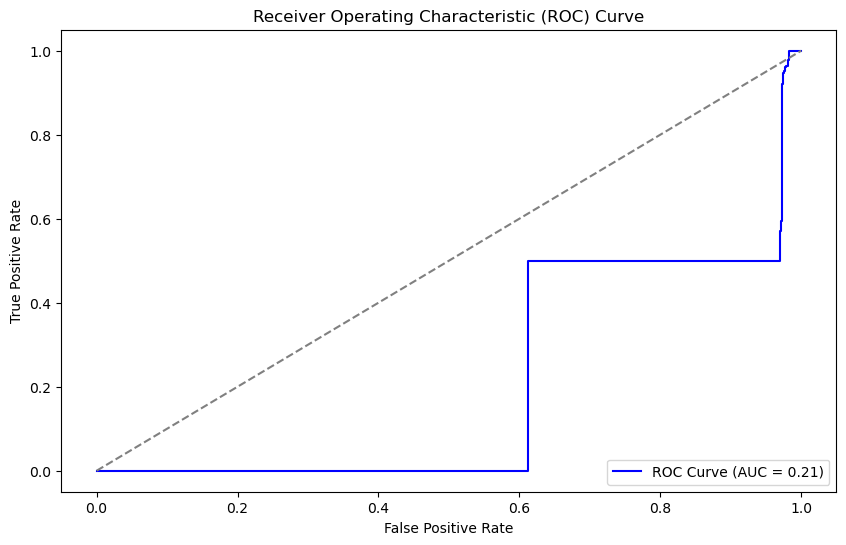

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    silhouette_score, davies_bouldin_score, roc_auc_score, roc_curve, 
    adjusted_rand_score, f1_score
)
from sklearn.preprocessing import StandardScaler
from fcmeans import FCM  # pip install fuzzy-c-means
from scipy.spatial.distance import cdist
from sklearn.neighbors import NearestNeighbors

# Load and preprocess the dataset
#file_path = r"C:\Users\psbis\2024 Clustering Autoencoder Mahalobish distance\pima.csv"
#file_path = r"C:\Users\psbis\2024 Clustering Autoencoder Mahalobish distance\parkinsons.csv"
#file_path = r"C:\Users\psbis\2024 Clustering Autoencoder Mahalobish distance\heart.csv"
#file_path = r"C:\Users\psbis\2024 Clustering Autoencoder Mahalobish distance\hepatitis.csv"
#file_path = r"C:\Users\psbis\2024 Clustering Autoencoder Mahalobish distance\ionosphere.csv"
#file_path = r"C:\Users\psbis\2024 Clustering Autoencoder Mahalobish distance\anemia.csv"
#file_path = r"C:\Users\psbis\2024 Clustering Autoencoder Mahalobish distance\syn1.csv"
file_path = r"C:\Users\psbis\2024 Clustering Autoencoder Mahalobish distance\syn2.csv"

data = pd.read_csv(file_path)

X = data.iloc[:, :-1]
y_true = data.iloc[:, -1]  # Ground truth for evaluation

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Parameters
n_clusters = 3
fuzziness = 2.0
noise_distance = 1.5

# Fuzzy C-Means with Noise Cluster
class FCMWithNoiseCluster:
    def __init__(self, n_clusters, fuzziness, noise_distance):
        self.n_clusters = n_clusters
        self.fuzziness = fuzziness
        self.noise_distance = noise_distance

    def fit(self, X):
        fcm = FCM(n_clusters=self.n_clusters)
        fcm.fit(X)
        self.memberships = fcm.u
        self.centers = fcm.centers

        # Add noise cluster
        distances = np.min(np.linalg.norm(X[:, None] - self.centers, axis=2), axis=1)
        noise_membership = 1 / (1 + (distances / self.noise_distance) ** (2 / (self.fuzziness - 1)))
        self.memberships = np.hstack((self.memberships, noise_membership[:, None]))

    def predict(self, X):
        return np.argmax(self.memberships, axis=1)

# Apply FCM with Noise Cluster
fcm_nc = FCMWithNoiseCluster(n_clusters=n_clusters, fuzziness=fuzziness, noise_distance=noise_distance)
fcm_nc.fit(X_scaled)
labels = fcm_nc.predict(X_scaled)

# Identify noise points (outliers)
outlier_mask = labels == n_clusters
outliers = X_scaled[outlier_mask]
outliers_count = len(outliers)
outliers_percentage = (outliers_count / len(X_scaled)) * 100

# Evaluation Metrics
silhouette = silhouette_score(X_scaled, labels[:len(X_scaled)])
davies_bouldin = davies_bouldin_score(X_scaled, labels[:len(X_scaled)])
s_db_ratio = silhouette / (davies_bouldin + 1e-5)

# Adjusted Rand Index (ARI)
ari = adjusted_rand_score(y_true, labels[:len(y_true)])

# F1 Score (Binary outlier detection)
binary_labels = (labels == n_clusters).astype(int)  # 1 for outliers, 0 for inliers
f1 = f1_score(y_true, binary_labels, average='weighted')

# Hubness Score
def hubness_score(X, k=5):
    nbrs = NearestNeighbors(n_neighbors=k).fit(X)
    indices = nbrs.kneighbors(X, return_distance=False)
    hubness = np.bincount(indices.flatten(), minlength=len(X))
    return np.mean(hubness), np.std(hubness)

hubness_mean, hubness_std = hubness_score(X_scaled, k=5)

# AUC Calculation
predicted_scores = fcm_nc.memberships[:, -1]
fpr, tpr, _ = roc_curve(y_true, predicted_scores)
roc_auc = roc_auc_score(y_true, predicted_scores)

# Print Metrics
# print("Silhouette Score:", silhouette)
# print("Davies-Bouldin Index:", davies_bouldin)
# print("S/DB Ratio:", s_db_ratio)
# print("Adjusted Rand Index (ARI):", ari)
# print("F1 Score:", f1)
# print("Hubness Mean:", hubness_mean)
# print("Hubness Std Dev:", hubness_std)
# print("Number of Outliers:", outliers_count)
# print(f"Percentage of Outliers: {outliers_percentage:.2f}%")
# print("AUC Value:", roc_auc)

# Compute Hubness Score
hub_score = hubness_score(X_scaled, k=5)

# Print Metrics
print("Silhouette Score:", np.round(silhouette, 3))
print("Davies-Bouldin Index:", np.round(davies_bouldin, 3))
print("S/DB Ratio:", np.round(s_db_ratio, 3))
print("Adjusted Rand Index (ARI):", np.round(ari, 3))
print("F1-Score:", np.round(f1, 3))
print("Hubness Score:", np.round(hub_score, 3))
print("AUC Value:", np.round(roc_auc, 3))

# Visualization: ROC Curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()
